In [55]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from scipy import integrate, interpolate, special

from dotenv import load_dotenv
load_dotenv(override=True)

ROOT_PATH = os.environ.get('ROOT_PATH')
if not ROOT_PATH in sys.path: sys.path.append(ROOT_PATH)

from main_code.utils.constants import *
from main_code.utils.CosmoFunc import *
from main_code.utils.logging_config import get_logger
from main_code.utils.filepaths import (
    LOGDIST_OUTPUT_FILEPATH
)
from main_code.step_12_smoothed_field import combine_my_logdist, generate_grids, get_supergalactic_coords, get_smoothing_length

from astropy import units as u
from astropy.coordinates import SkyCoord

SMIN_SETTING = int(os.environ.get('SMIN_SETTING'))
FP_FIT_METHOD = int(os.environ.get('FP_FIT_METHOD'))

Best-value k: 2.2097934422021233


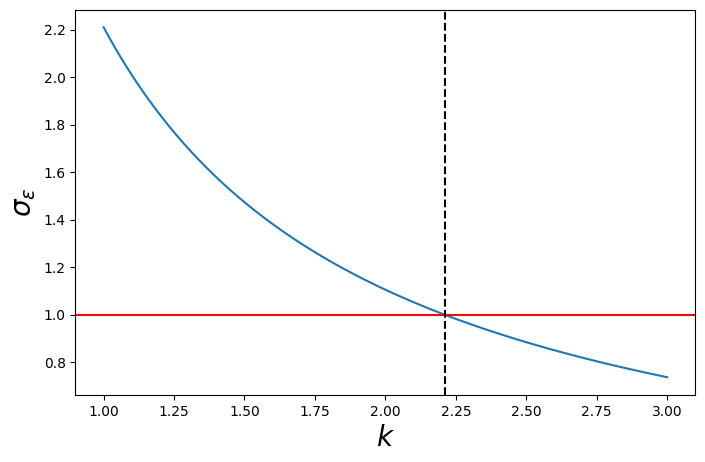

In [67]:
# def calculate_veldisp_chisq(k)

# Load SDSS
df_sdss = pd.read_csv("../../data/processed/rsi_derived/sdss.csv")[['tmass', 's', 'es']]

# Load LAMOST
df_lamost = pd.read_csv("../../data/processed/rsi_derived/lamost.csv")[['tmass', 's', 'es']]

# Merge
df = df_sdss.merge(df_lamost, on='tmass', how='inner', suffixes=('_sdss', '_lamost'))

# Unpack data
s_sdss = df['s_sdss'].to_numpy().reshape(-1, 1)
es_sdss = df['es_sdss'].to_numpy().reshape(-1, 1)
s_lamost = df['s_lamost'].to_numpy().reshape(-1, 1)
es_lamost = df['es_lamost'].to_numpy().reshape(-1, 1)

# List of constant to be tested
k = np.linspace(1.0, 3.0, 1000)[np.newaxis, :]

# Calculate chi-squared
chisq = (s_sdss - s_lamost) / (k * np.sqrt(es_sdss**2 + es_lamost**2))

# Calculate std of chi-squared
chisq_std = np.std(chisq, axis=0)

# Plot k vs scatter
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(k.ravel(), chisq_std)
ax.set_xlabel(r'$k$', fontsize=20)
ax.set_ylabel(r'$\sigma_\epsilon$', fontsize=20)


# Spline interpolation
k_spline = interpolate.splrep(k.ravel(), chisq_std, s=0)

# Predict when k gives std = 1
k_best = sp.interpolate.splev(1.0, k_spline)
print(f"Best-value k: {k_best}")

ax.axhline(y=1, c='r')
ax.axvline(x=k_best, c='k', ls='--')

Bro $k = \sigma_\epsilon$...

# Error estimates: Monte Carlo bootstrapping

Best value of k = 2.2098 ± 0.0127


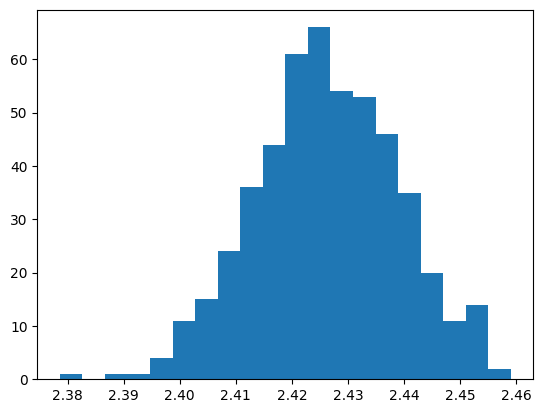

In [84]:
# Load SDSS
df_sdss = pd.read_csv("../../data/processed/rsi_derived/sdss.csv")[['tmass', 's', 'es']]

# Load LAMOST
df_lamost = pd.read_csv("../../data/processed/rsi_derived/lamost.csv")[['tmass', 's', 'es']]

# Merge
df = df_sdss.merge(df_lamost, on='tmass', how='inner', suffixes=('_sdss', '_lamost'))

# List of constant to be tested
k = np.linspace(1.0, 3.0, 1000)[np.newaxis, :]

k_best_list = []
chisq_upper_list = []
chisq_lower_list = []
for boot in range(500):

    df_ = df.copy()

    # Unpack data
    s_sdss = df_['s_sdss'].to_numpy().reshape(-1, 1)
    es_sdss = df_['es_sdss'].to_numpy().reshape(-1, 1)
    s_lamost = df_['s_lamost'].to_numpy().reshape(-1, 1)
    es_lamost = df_['es_lamost'].to_numpy().reshape(-1, 1)

    # For the first simulation, use the measurements directly
    if (boot > 0):
        s_sdss = s_sdss + es_sdss * np.random.normal(size=es_sdss.shape)
        s_lamost = s_lamost + es_lamost * np.random.normal(size=es_lamost.shape)

    # Calculate chi-squared
    chisq = (s_sdss - s_lamost) / (np.sqrt(es_sdss**2 + es_lamost**2))

    # Calculate std of chi-squared (equal to the scaling constant that makes std=1)
    chisq_std = np.std(chisq, axis=0)[0]

    # Save all results
    k_best_list.append(chisq_std)

plt.hist(k_best_list[1:], bins=20)
print(f"Best value of k = {np.round(k_best_list[0], 4)} ± {np.round(np.std(k_best_list[1:]), 4)}")